In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import time
from datetime import datetime
from datetime import timedelta
sns.set()

In [68]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override(tickers="JPM", period = '1d', start='2012-01-01', end='2017-12-31')
df_full = pdr.get_data_yahoo("JPM", start="2012-01-01", end='2017-12-31').reset_index()

yf.pdr_override(tickers="JPM", period = '1d', start='2018-01-01', end='2019-12-31')
test_df_full = pdr.get_data_yahoo("JPM", start="2018-01-01", end='2019-12-31').reset_index()

df_full.to_csv('data_raw/JPM_2012_2018.csv',index=False)
test_df_full.to_csv('data_raw/JPM_2018_2020.csv', index=False)

df_full.head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,35.189999,34.009998,34.060001,34.980000,44102800.0,25.737307
1,2012-01-04,35.150002,34.330002,34.439999,34.950001,36571200.0,25.900354
2,2012-01-05,35.919998,34.400002,34.709999,35.680000,38381400.0,26.441332
3,2012-01-06,35.770000,35.139999,35.689999,35.360001,33160600.0,26.204189
4,2012-01-09,35.680000,34.990002,35.439999,35.299999,23001800.0,26.159729


In [69]:
df_full = pd.read_csv('data_raw/JPM_2012_2018.csv')

In [70]:
# medium term instead of next day
# df_full["Adj Org"] = df_full["Adj Close"]
# df_full["Adj Close"] = df_full["Adj Close"].shift(-1)
# df_full = df_full[:-1]
df_full.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,35.189999,34.009998,34.060001,34.980000,44102800.0,25.737307
1,2012-01-04,35.150002,34.330002,34.439999,34.950001,36571200.0,25.900354
2,2012-01-05,35.919998,34.400002,34.709999,35.680000,38381400.0,26.441332
3,2012-01-06,35.770000,35.139999,35.689999,35.360001,33160600.0,26.204189
4,2012-01-09,35.680000,34.990002,35.439999,35.299999,23001800.0,26.159729


## Stacked Decision Tree Ensembles using XGBoost and Encoded Features (EXGBEF)

In [71]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,35.189999,34.009998,34.060001,34.980000,44102800.0,25.737307
1,2012-01-04,35.150002,34.330002,34.439999,34.950001,36571200.0,25.900354
2,2012-01-05,35.919998,34.400002,34.709999,35.680000,38381400.0,26.441332
3,2012-01-06,35.770000,35.139999,35.689999,35.360001,33160600.0,26.204189
4,2012-01-09,35.680000,34.990002,35.439999,35.299999,23001800.0,26.159729


In [33]:
minmax = MinMaxScaler().fit(df.loc[:, "Adj Close"].values.reshape((-1,1)))
close_normalize = minmax.transform(df.loc[:, "Adj Close"].values.reshape((-1,1))).reshape((-1))

In [34]:
close_normalize.shape

(1509,)

In [35]:
### Creating features through an encoder
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.compat.v1.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.compat.v1.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.compat.v1.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.compat.v1.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.compat.v1.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.compat.v1.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.compat.v1.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.compat.v1.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.compat.v1.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [36]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape, close_normalize.shape

c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.22358371 time: 0.015518903732299805
epoch: 20 loss: 0.04113723 time: 0.01099395751953125
epoch: 30 loss: 0.036954876 time: 0.007999658584594727
epoch: 40 loss: 0.030568656 time: 0.009999990463256836
epoch: 50 loss: 0.021708308 time: 0.006996870040893555
epoch: 60 loss: 0.01330535 time: 0.010995864868164062
epoch: 70 loss: 0.069366604 time: 0.0070002079010009766
epoch: 80 loss: 0.13620694 time: 0.010000228881835938
epoch: 90 loss: 0.0286179 time: 0.011996030807495117
epoch: 100 loss: 0.15778212 time: 0.011009454727172852


((1509, 32), (1509,))

In [37]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [38]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(n_estimators=500)

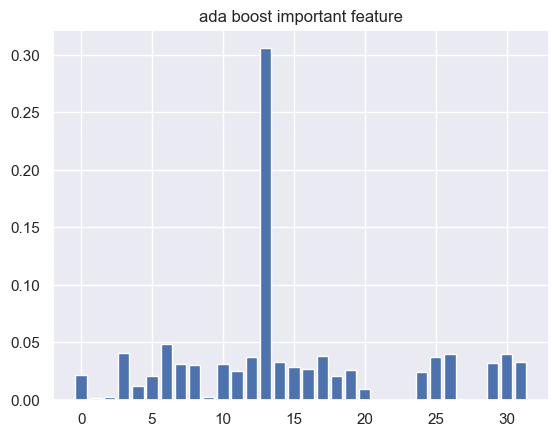

In [39]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

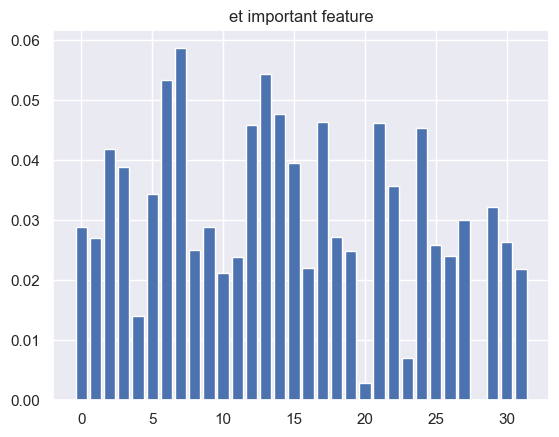

In [40]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

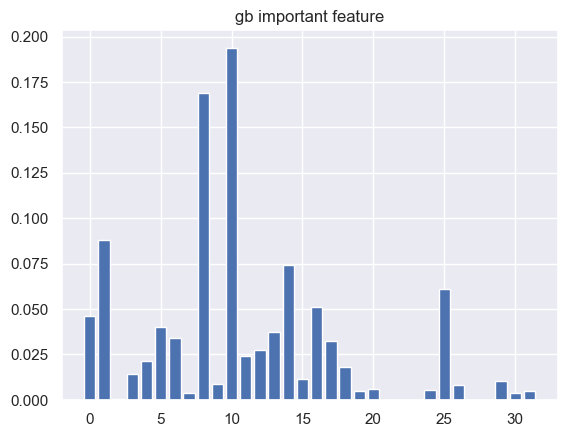

In [41]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

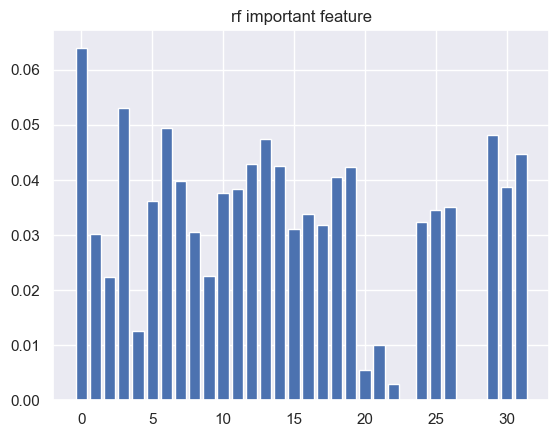

In [42]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [43]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [44]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

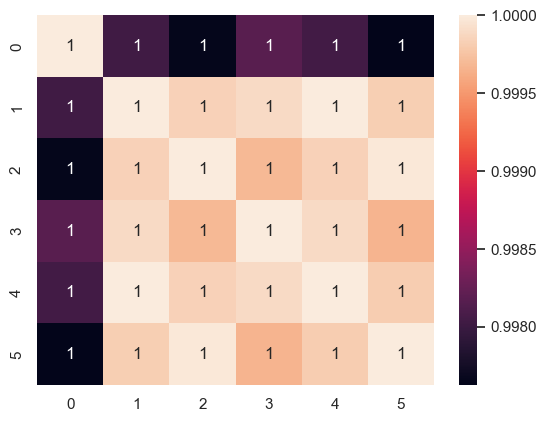

In [45]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

### Stacking

In [46]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, objective='reg:logistic', predictor='auto', ...)

In [74]:
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [48]:
clf.feature_importances_

array([0.8489003 , 0.02380906, 0.05205632, 0.01308467, 0.00570334,
       0.05644636], dtype=float32)

In [49]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

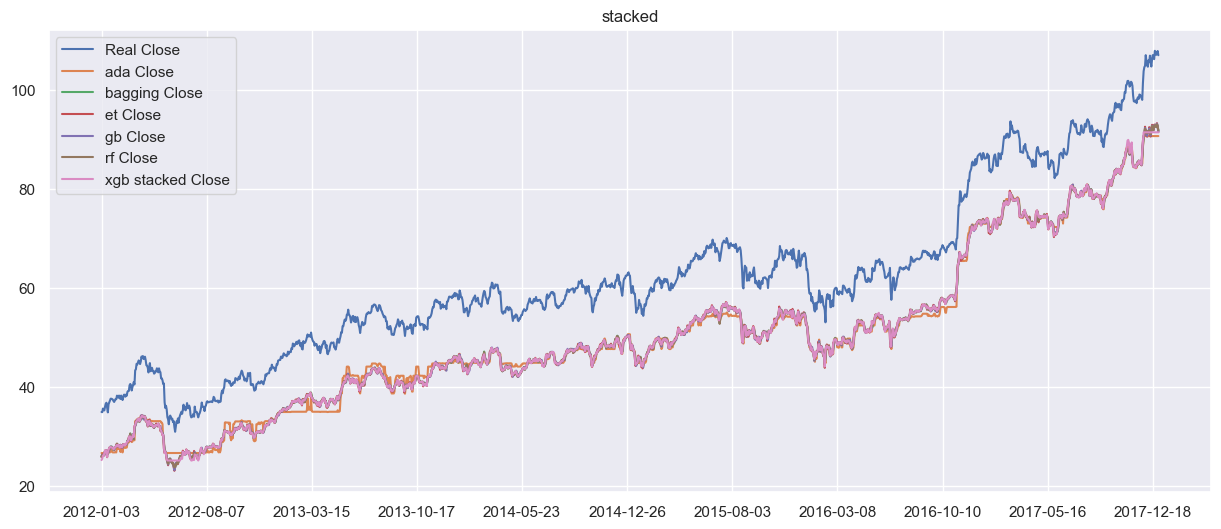

In [75]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::150], date_original[::150])
plt.title('stacked')
plt.show()

In [51]:
ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [52]:
predict(30, history = 5)

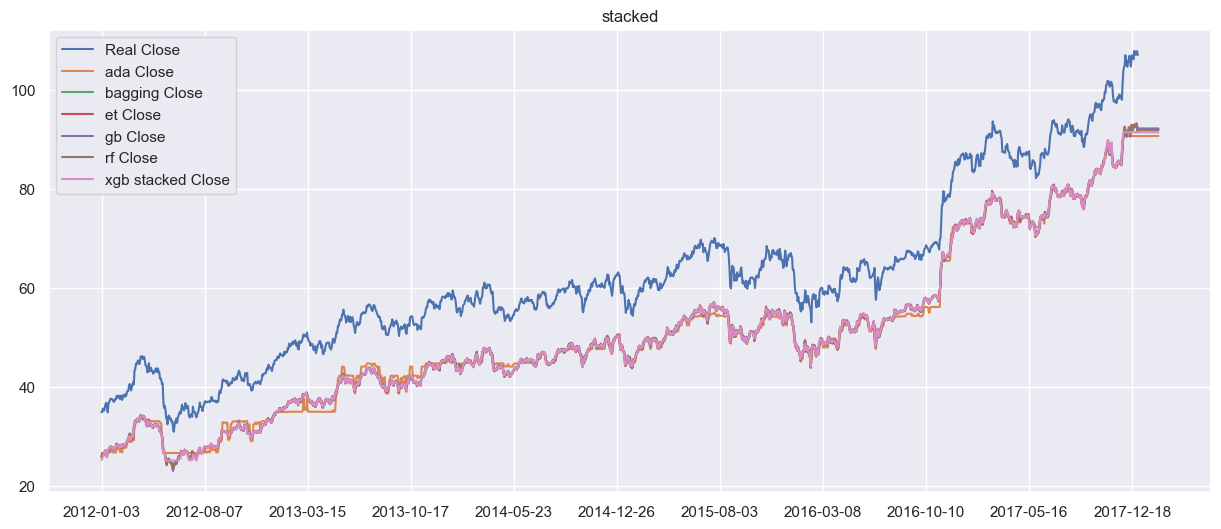

In [77]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::150], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::150])
plt.title('stacked')
plt.show()

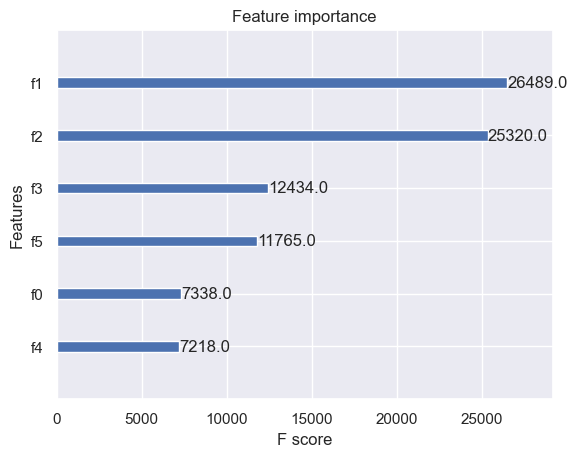

In [54]:
### Arima Slightly more important than RNN, but clearly overfits (most likley represents lagged close more than anything else)
from xgboost import plot_importance
plot_importance(clf)
plt.show()

### Assemble test dataset

In [55]:
df_test = pd.read_csv('data_raw/JPM_2018_2020.csv')
date_ori = pd.to_datetime(df_test.iloc[:, 0]).tolist()
df_test.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-02,108.019997,106.809998,107.629997,107.949997,13578800.0,93.384323
1,2018-01-03,108.489998,107.480003,107.860001,108.059998,11901000.0,93.479469
2,2018-01-04,110.029999,108.199997,108.360001,109.040001,12953700.0,94.818619
3,2018-01-05,109.550003,107.779999,109.260002,108.339996,14155000.0,94.209908
4,2018-01-08,108.680000,107.699997,108.150002,108.500000,12466500.0,94.349045
